# HW1 - Autoencoder

In [33]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torchvision import transforms
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.decomposition import PCA

# Set random seed for reproducibility
manualSeed = 1337
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  1337


In [55]:
data_root = './data'

workers = 1
ngpu = 1

image_size = 32
nc = 3

dataset_fraction = 0.1
num_epochs = 50
batch_size = 64

use_normalization = False
use_pca = False


Files already downloaded and verified
Files already downloaded and verified
tensor([6, 9, 1, 7, 5, 8, 6, 3])
min = 0.0 max = 1.0


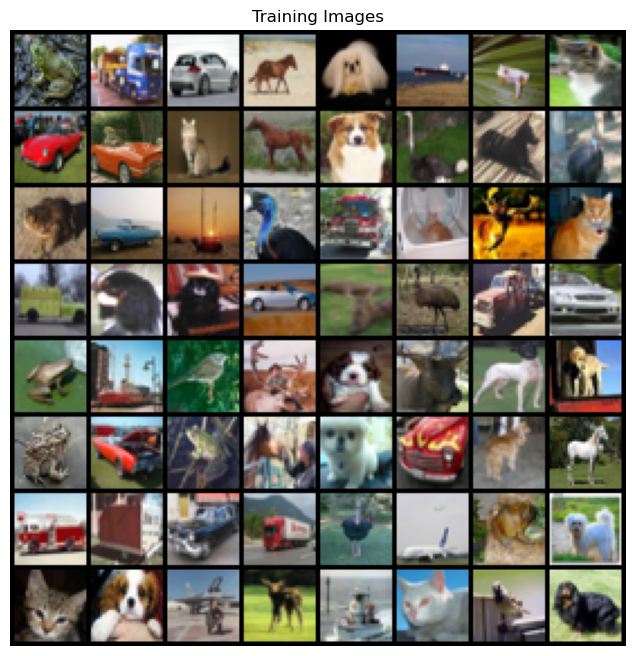

In [35]:
# Init data

if use_normalization:
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
else:
    transform = transforms.ToTensor()

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0)
                      else "mps:0" if torch.backends.mps.is_available() and ngpu > 0
                      else "cpu")

def get_subset(dataset, fraction):
    full_size = len(dataset)
    new_size = int(fraction * full_size)
    idxs = torch.randperm(full_size)[:new_size]
    return torch.utils.data.Subset(full_trainset, idxs)

full_trainset = dset.CIFAR10(root=data_root, train=True, download=True, transform=transform)
trainset = get_subset(full_trainset, dataset_fraction)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=workers)

full_testset = dset.CIFAR10(root=data_root, train=False, download=True, transform=transform)
testset = get_subset(full_testset, dataset_fraction)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=workers)

# Plot some training images
real_batch = next(iter(trainloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
print(real_batch[1].to(device)[:8].cpu())
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64].cpu(), padding=2, normalize=True),(1,2,0)))
print(f'min = {torch.min(real_batch[0].to(device)).cpu()}', f'max = {torch.max(real_batch[0].to(device)).cpu()}')

In [80]:
# Model
class CnnClassifier(nn.Module):
    def __init__(self, ngpu): 
        super().__init__()
        
        self.ngpu = ngpu
        
        self.conv = torch.nn.Sequential(
            # input is nc x 32 x 32
            nn.Conv2d(nc, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # state size. 64 x 16 x 16
            nn.Conv2d(64, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # state size. 16 x 8 x 8
        )
        
        self.fc = torch.nn.Sequential(         
            nn.Linear(16 * 8 * 8, 784),
            nn.ReLU(inplace=True),
            nn.Linear(784, 10),
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class FcClassifier(nn.Module):
    def __init__(self, ngpu, width, depth=3):
        super().__init__()

        self.ngpu = ngpu
        self.width = width
        self.depth = depth

        self.fc = nn.Sequential(
            nn.Linear(nc * image_size * image_size, width),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.5),
        )

        self.hidden1 = nn.Sequential(
            nn.Linear(width, width),
            nn.ReLU(inplace=True),
        )

        self.hidden2 = nn.Sequential(
            nn.Linear(width, width),
            nn.ReLU(inplace=True),
            nn.Linear(width, width),
            nn.ReLU(inplace=True),
            nn.Linear(width, width),
            nn.ReLU(inplace=True),
            nn.Linear(width, width),
            nn.ReLU(inplace=True),
            nn.Linear(width, width),
            nn.ReLU(inplace=True),
            nn.Linear(width, width),
            nn.ReLU(inplace=True),
        )

        self.final = nn.Sequential(
            nn.Linear(self.width, 10),
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc(x)
        if depth > 3:
            x = self.hidden1(x)
        if depth == 10:
            x = self.hidden2(x)
        x = self.final(x)
        return x


In [85]:
# Parameters

# sgd_lr = 0.01
sgd_lrs = [0.01, 0.1, 1]
# momentum = 0.9
momentums = [0.09, 0.9, 0.99]
adam_lr = 1e-3
beta1 = 0.5
weight_decay = 0.01
# std_dev = 0.001
std_devs = [0.001]

use_adam = False
use_xavier = False
use_weight_decay = False

losses_interval = 10

In [86]:
# Training:
def train_model(model, optimizer, loss_criterion, verbose=False):
    training_losses = []
    training_losses_epochs = []
    test_losses = []
    loss_iters = 0
    last_iters = 0
    test_accuracies = []
    train_accuracies = []

    print("Starting Training Loop...")
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        correct_class = 0
        total_labels = 0
        for i, data in enumerate(trainloader) :
            inputs, labels = [d.to(device) for d in data]
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            total_labels += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_class += (predicted == labels).sum().item()

            if i % losses_interval == losses_interval - 1:
                mean_loss = running_loss / losses_interval
                if verbose:
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {mean_loss:.3f}')
                training_losses.append(mean_loss)
                running_loss = 0.0
                loss_iters += 1

        training_losses_epochs.append(np.mean(training_losses[last_iters:loss_iters]))
        train_accuracy = correct_class / total_labels
        train_accuracies.append(train_accuracy)
        last_iters = loss_iters

        model.eval()
        correct_class = 0
        total_labels = 0
        total_loss = 0
        with torch.no_grad():
            for data in testloader:
                inputs, labels = [d.to(device) for d in data]
                outputs = model(inputs)
                loss = loss_criterion(outputs, labels)
                total_loss += loss.item() * len(data)  # doing weighted average over batches
                _, predicted = torch.max(outputs.data, 1)
                total_labels += labels.size(0)
                correct_class += (predicted == labels).sum().item()
        test_loss = total_loss / len(testloader)
        test_losses.append(test_loss)
        test_accuracy = correct_class / total_labels
        test_accuracies.append(test_accuracy)

        if verbose:
            print(f"[{epoch + 1}/{num_epochs}]\tTest Loss:\t{training_losses_epochs[-1]:.4f}")
            print(f"[{epoch + 1}/{num_epochs}]\tTrain Loss:\t{test_loss:.4f}")
            print(f"[{epoch + 1}/{num_epochs}]\tTrain accuracy:\t{train_accuracy * 100:.1f}%")
            print(f"[{epoch + 1}/{num_epochs}]\tTest accuracy:\t{test_accuracy * 100:.1f}%")

    return training_losses_epochs, test_losses, train_accuracies, test_accuracies
depths = [3, 4, 10]
full_train_losses_epochs = []
full_test_losses = []
full_train_accuracies = []
full_test_accuracies = []

for std_dev in std_devs:
    for momentum in momentums:
        for sgd_lr in sgd_lrs:
# for depth in depths:
            def init_weights(m):
                if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                    if use_xavier:
                        nn.init.xavier_uniform(m.weight)
                    else:
                        nn.init.normal_(m.weight, std=std_dev)
            model = CnnClassifier(ngpu).to(device)
            loss_criterion = nn.CrossEntropyLoss()
            model.apply(init_weights)
            if use_adam:
                optimizer = torch.optim.Adam(model.parameters(), lr=adam_lr)
            else:
                if use_weight_decay:
                    optimizer = torch.optim.SGD(model.parameters(), lr=sgd_lr, momentum=momentum, weight_decay=weight_decay)
                else:
                    optimizer = torch.optim.SGD(model.parameters(), lr=sgd_lr, momentum=momentum)
            print("-------------------------------------------------------------------")
            print(f"std_dev = {std_dev},\tmomentum = {momentum},\tsgd_lr = {sgd_lr}")
            cur_train_losses_epochs, cur_test_losses, cur_train_accuracies, cur_test_accuracies = train_model(model, optimizer, loss_criterion)
            full_train_losses_epochs.append(cur_train_losses_epochs)
            full_test_losses.append(cur_test_losses)
            full_train_accuracies.append(cur_train_accuracies)
            full_test_accuracies.append(cur_test_accuracies)
            print(f"Best train loss:\t{min(cur_train_losses_epochs):.3f}")
            print(f"Best test loss:\t{min(cur_test_losses):.3f}")
            print(f"Best train accuracy:\t{max(cur_train_accuracies) * 100:.1f}%")
            print(f"Best test accuracy:\t{max(cur_test_accuracies) * 100:.1f}%")
            print(f"Final train loss:\t{cur_train_losses_epochs[-1]:.3f}")
            print(f"Final test loss:\t{cur_test_losses[-1]:.3f}")
            print(f"Final train accuracy:\t{cur_train_accuracies[-1] * 100:.1f}%")
            print(f"Final test accuracy:\t{cur_test_accuracies[-1] * 100:.1f}%")

-------------------------------------------------------------------
std_dev = 0.001,	momentum = 0.09,	sgd_lr = 0.01
Starting Training Loop...


  0%|          | 0/50 [00:00<?, ?it/s]

Best train loss:	2.301
Best test loss:	4.606
Best train accuracy:	10.6%
Best test accuracy:	9.8%
Final train loss:	2.301
Final test loss:	4.611
Final train accuracy:	10.6%
Final test accuracy:	9.8%
-------------------------------------------------------------------
std_dev = 0.001,	momentum = 0.09,	sgd_lr = 0.1
Starting Training Loop...


  0%|          | 0/50 [00:00<?, ?it/s]

Best train loss:	2.301
Best test loss:	4.607
Best train accuracy:	10.6%
Best test accuracy:	10.5%
Final train loss:	2.302
Final test loss:	4.612
Final train accuracy:	9.8%
Final test accuracy:	9.8%
-------------------------------------------------------------------
std_dev = 0.001,	momentum = 0.09,	sgd_lr = 1
Starting Training Loop...


  0%|          | 0/50 [00:00<?, ?it/s]

Best train loss:	2.304
Best test loss:	4.609
Best train accuracy:	11.3%
Best test accuracy:	11.2%
Final train loss:	2.307
Final test loss:	4.621
Final train accuracy:	9.6%
Final test accuracy:	9.6%
-------------------------------------------------------------------
std_dev = 0.001,	momentum = 0.9,	sgd_lr = 0.01
Starting Training Loop...


  0%|          | 0/50 [00:00<?, ?it/s]

Best train loss:	2.301
Best test loss:	4.609
Best train accuracy:	10.6%
Best test accuracy:	10.5%
Final train loss:	2.302
Final test loss:	4.612
Final train accuracy:	10.1%
Final test accuracy:	9.8%
-------------------------------------------------------------------
std_dev = 0.001,	momentum = 0.9,	sgd_lr = 0.1
Starting Training Loop...


  0%|          | 0/50 [00:00<?, ?it/s]

Best train loss:	2.304
Best test loss:	4.606
Best train accuracy:	10.6%
Best test accuracy:	10.5%
Final train loss:	2.305
Final test loss:	4.610
Final train accuracy:	10.2%
Final test accuracy:	9.4%
-------------------------------------------------------------------
std_dev = 0.001,	momentum = 0.9,	sgd_lr = 1
Starting Training Loop...


  0%|          | 0/50 [00:00<?, ?it/s]

Best train loss:	2.329
Best test loss:	4.629
Best train accuracy:	10.9%
Best test accuracy:	11.2%
Final train loss:	2.341
Final test loss:	4.732
Final train accuracy:	9.9%
Final test accuracy:	9.2%
-------------------------------------------------------------------
std_dev = 0.001,	momentum = 0.99,	sgd_lr = 0.01
Starting Training Loop...


  0%|          | 0/50 [00:00<?, ?it/s]

Best train loss:	2.302
Best test loss:	4.609
Best train accuracy:	10.9%
Best test accuracy:	10.5%
Final train loss:	2.304
Final test loss:	4.610
Final train accuracy:	9.6%
Final test accuracy:	9.2%
-------------------------------------------------------------------
std_dev = 0.001,	momentum = 0.99,	sgd_lr = 0.1
Starting Training Loop...


  0%|          | 0/50 [00:00<?, ?it/s]

Best train loss:	2.312
Best test loss:	4.623
Best train accuracy:	11.1%
Best test accuracy:	11.2%
Final train loss:	2.329
Final test loss:	4.643
Final train accuracy:	10.3%
Final test accuracy:	10.5%
-------------------------------------------------------------------
std_dev = 0.001,	momentum = 0.99,	sgd_lr = 1
Starting Training Loop...


  0%|          | 0/50 [00:00<?, ?it/s]

Best train loss:	2.412
Best test loss:	4.733
Best train accuracy:	10.9%
Best test accuracy:	11.2%
Final train loss:	2.669
Final test loss:	5.101
Final train accuracy:	10.2%
Final test accuracy:	9.6%


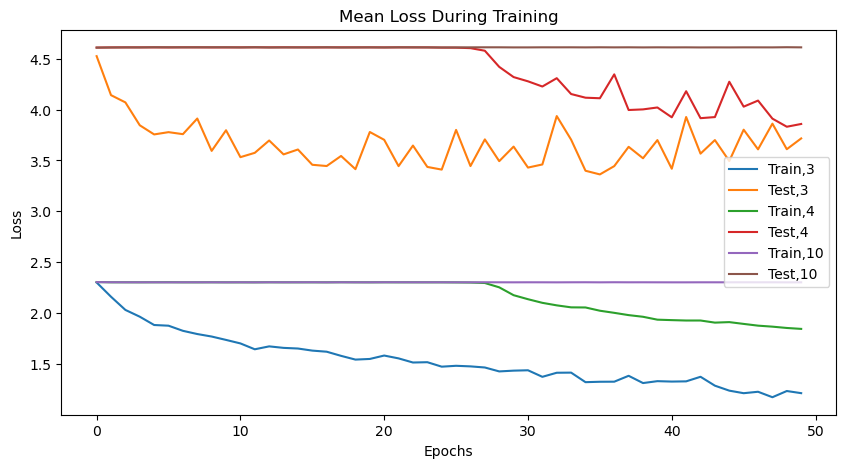

In [83]:
plt.figure(figsize=(10,5))
for i in range(len(full_train_losses_epochs)):
    plt.plot(full_train_losses_epochs[i], label='Train,' + str(depths[i]))
    plt.plot(full_test_losses[i], label="Test," + str(depths[i]))
plt.title("Mean Loss During Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

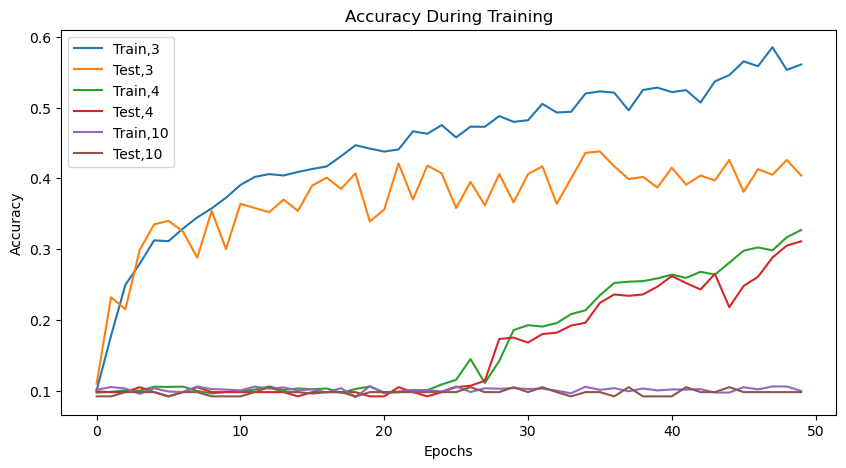

In [84]:
plt.figure(figsize=(10,5))
for i in range(len(full_test_accuracies)):
    plt.plot(full_train_accuracies[i], label='Train,' + str(depths[i]))
    plt.plot(full_test_accuracies[i], label="Test," + str(depths[i]))
plt.title("Accuracy During Training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()